In [1]:
import sys 
sys.path.append('../')
from dlim.model import DLIM 
from dlim.dataset import Data_model
from dlim.api import DLIM_API
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from numpy.random import choice
from src_simulate_data.sim_data import Simulated
import numpy as np 
from sklearn.metrics import r2_score
import matplotlib.patches as mpatches


In [2]:

type_f = "exp"
nb_var = 30
data_simulated = Simulated(nb_var, type_f)
data = Data_model(data=pd.DataFrame(data_simulated.data), n_variables=2)

thres = 1.2
A_id = [i for i, el  in enumerate(data_simulated.A) if el >= 2.7 or el < 1.5]
B_id = [i for i, el  in enumerate(data_simulated.B) if el >= 2.7 or el < 1.5]
nA_id = [i for i, el  in enumerate(data_simulated.A) if i not in A_id]
nB_id = [i for i, el  in enumerate(data_simulated.B) if i not in B_id]
train_id = [i for i, el  in enumerate(data_simulated.data) if el[0] in A_id and el[1] in B_id]
val_id = [i for i in range(data_simulated.data.shape[0]) if i not in train_id]

train_data = data.subset(train_id)
val_data = data.subset(val_id)


model = DLIM(n_variables = train_data.nb_val, hid_dim = 32, nb_layer = 0)
dlim_regressor = DLIM_API(model=model, flag_spectral=True)
losses = dlim_regressor.fit(train_data, lr = 1e-3, nb_epoch=300, batch_size=32, emb_regularization=0, \
                            save_path= None)
fit_v, vari_v, lat_v = dlim_regressor.predict(val_data.data[:,:-1], detach=True) 
fit_t, var_t, lat_t = dlim_regressor.predict(train_data.data[:, :-1], detach=True)


spectral gap = 0.7333333492279053
spectral gap = 0.8666664361953735


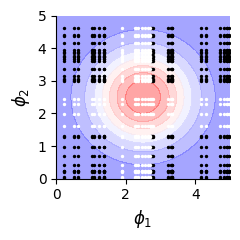

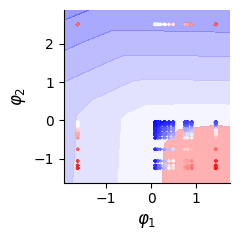

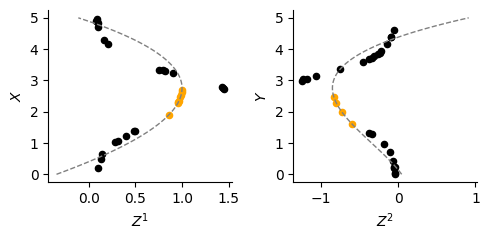

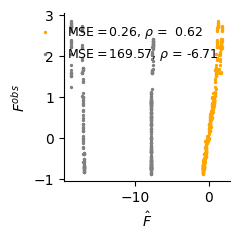

In [3]:
fig, ax = plt.subplots(1, figsize=(2.5, 2.5))
data_simulated.plot(ax)
ax.scatter(data_simulated.A[data.data[train_id, 0].int()], data_simulated.B[data.data[train_id, 1].int()], s=2, marker="o", c="black")
ax.scatter(data_simulated.A[data.data[val_id, 0].int()], data_simulated.B[data.data[val_id, 1].int()], s=2, marker="o", c="white")
# ax.plot([1.5, 5], [1.5, 1.5], linewidth=2, linestyle="--", c="black")
# ax.plot([1.5, 1.5], [1.5, 5], linewidth=2, linestyle="--", c="black")
for el in ["top", "right"]:
    ax.spines[el].set_visible(False)
plt.tight_layout()
# plt.savefig(f"../img/extend/{type_f}_land_data.png", dpi=300, transparent=True)
plt.show()

fig, bx = plt.subplots(1, figsize=(2.5, 2.5))
dlim_regressor.plot(bx, data)
bx.scatter(dlim_regressor.model.genes_emb[0][data.data[train_id, 0].long()].detach(),
          dlim_regressor.model.genes_emb[1][data.data[train_id, 1].long()].detach(),
           c=data.data[train_id, -1], s=2, cmap="bwr", marker="x")
for el in ["top", "right"]:
    bx.spines[el].set_visible(False)
# bx.set_aspect(1)
plt.tight_layout()
# plt.savefig(f"../img/extend/{type_f}_land_pred.png", dpi=300, transparent=True)
plt.show()

dlim_regressor.model.train_convert(A_id, data_simulated.A[A_id], 0)
dlim_regressor.model.train_convert(B_id, data_simulated.B[B_id], 1)
dlim_regressor.model.update_emb(nA_id, data_simulated.A[nA_id], 0)
dlim_regressor.model.update_emb(nB_id, data_simulated.B[nB_id], 1)

fig, (ax, bx) = plt.subplots(1, 2, figsize=(5, 2.5))
ax.scatter(dlim_regressor.model.genes_emb[0][A_id].detach(), data_simulated.A[A_id], c="black", s=20)
ax.scatter(dlim_regressor.model.genes_emb[0][nA_id].detach(), data_simulated.A[nA_id], c="orange", s=20)
ax.plot(np.polyval(dlim_regressor.model.conversion[0], np.linspace(0, 5, 100)), np.linspace(0, 5, 100), linewidth=1, linestyle="--", c="grey")
bx.scatter(dlim_regressor.model.genes_emb[1][B_id].detach(), data_simulated.B[B_id], c="black", s=20)
bx.scatter(dlim_regressor.model.genes_emb[1][nB_id].detach(), data_simulated.B[nB_id], c="orange", s=20)
bx.plot(np.polyval(dlim_regressor.model.conversion[1], np.linspace(0, 5, 100)), np.linspace(0, 5, 100), linewidth=1, linestyle="--", c="grey")
ax.set_ylabel("$X$")
ax.set_xlabel("$Z^1$")
bx.set_ylabel("$Y$")
bx.set_xlabel("$Z^2$")
for el in ["top", "right"]:
    ax.spines[el].set_visible(False)
    bx.spines[el].set_visible(False)
plt.tight_layout()
# plt.savefig(f"../img/extend/{type_f}_cor_bio.png", dpi=300, transparent=True)
plt.show()

fit_n, var_n, lat_n = dlim_regressor.predict(val_data.data[:, :-1], detach=True)
val_data_array = val_data.data[:, [-1]].numpy()
fig, ax = plt.subplots(1, figsize=(2.5, 2.5))
score = ((fit_n.flatten() -val_data_array.flatten())**2).mean()
score_v = ((fit_v.flatten() - val_data_array.flatten())**2).mean()

r2 = r2_score(fit_n.flatten(), val_data_array)
r2_v = r2_score(fit_v.flatten(), val_data_array)

ax.scatter(fit_n, val_data_array, s=2, c="orange", label=f"MSE$={score:.2f}$, $\\rho$ = {r2: 0.2f}")
ax.scatter(fit_v, val_data_array, s=2, c="grey", label=f"MSE$={score_v:.2f}$, $\\rho$ = {r2_v: 0.2f}")

ax.set_xlabel("$\\hat{F}$")
ax.set_ylabel("$F^{obs}$")
for el in ["top", "right"]:
    ax.spines[el].set_visible(False)
ax.legend(frameon=False, ncol=1, fontsize=9)
plt.tight_layout()
# plt.savefig(f"../img/extend/{type_f}new_fit.svg", dpi=300, transparent=True)
plt.show()

In [4]:

type_f = "bio"
nb_var = 30
data_simulated = Simulated(nb_var, type_f)
data = Data_model(data=pd.DataFrame(data_simulated.data), n_variables=2)

# choose the region of training 
thres = 1.2
A_id = [i for i, el  in enumerate(data_simulated.A) if el >= thres]
B_id = [i for i, el  in enumerate(data_simulated.B) if el >= thres]
nA_id = [i for i, el  in enumerate(data_simulated.A) if i not in A_id]
nB_id = [i for i, el  in enumerate(data_simulated.B) if i not in B_id]
train_id = [i for i, el  in enumerate(data_simulated.data) if el[0] in A_id and el[1] in B_id]
val_id = [i for i in range(data_simulated.data.shape[0]) if i not in train_id]

train_data = data.subset(train_id)
val_data = data.subset(val_id)


model = DLIM(n_variables = train_data.nb_val, hid_dim = 32, nb_layer = 0)
dlim_regressor = DLIM_API(model=model, flag_spectral=True)
losses = dlim_regressor.fit(train_data, lr = 1e-3, nb_epoch=300, batch_size=32, emb_regularization=0, \
                            save_path= None)
fit_v, vari_v, lat_v = dlim_regressor.predict(val_data.data[:,:-1], detach=True) 
fit_t, var_t, lat_t = dlim_regressor.predict(train_data.data[:, :-1], detach=True)


spectral gap = 0.6666659116744995
spectral gap = 0.6666663885116577


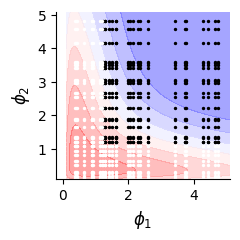

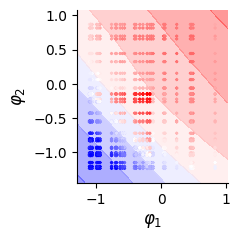

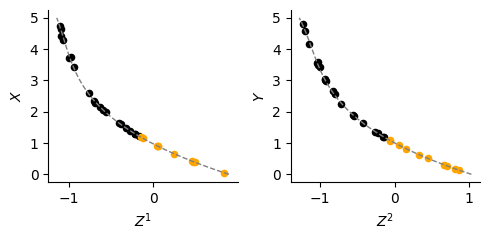

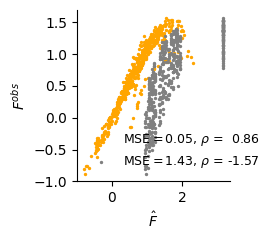

In [7]:
fig, ax = plt.subplots(1, figsize=(2.5, 2.5))
data_simulated.plot(ax)
ax.scatter(data_simulated.A[data.data[train_id, 0].int()], data_simulated.B[data.data[train_id, 1].int()], s=2, marker="o", c="black")
ax.scatter(data_simulated.A[data.data[val_id, 0].int()], data_simulated.B[data.data[val_id, 1].int()], s=2, marker="o", c="white")
# ax.plot([1.5, 5], [1.5, 1.5], linewidth=2, linestyle="--", c="black")
# ax.plot([1.5, 1.5], [1.5, 5], linewidth=2, linestyle="--", c="black")
for el in ["top", "right"]:
    ax.spines[el].set_visible(False)
plt.tight_layout()
# plt.savefig(f"../img/extend/{type_f}_land_data.png", dpi=300, transparent=True)
plt.show()

fig, bx = plt.subplots(1, figsize=(2.5, 2.5))
dlim_regressor.plot(bx, data)
bx.scatter(dlim_regressor.model.genes_emb[0][data.data[train_id, 0].long()].detach(),
          dlim_regressor.model.genes_emb[1][data.data[train_id, 1].long()].detach(),
           c=data.data[train_id, -1], s=2, cmap="bwr", marker="x")
for el in ["top", "right"]:
    bx.spines[el].set_visible(False)
# bx.set_aspect(1)
plt.tight_layout()
# plt.savefig(f"../img/extend/{type_f}_land_pred.png", dpi=300, transparent=True)
plt.show()

dlim_regressor.model.train_convert(A_id, data_simulated.A[A_id], 0)
dlim_regressor.model.train_convert(B_id, data_simulated.B[B_id], 1)
dlim_regressor.model.update_emb(nA_id, data_simulated.A[nA_id], 0)
dlim_regressor.model.update_emb(nB_id, data_simulated.B[nB_id], 1)

fig, (ax, bx) = plt.subplots(1, 2, figsize=(5, 2.5))
ax.scatter(dlim_regressor.model.genes_emb[0][A_id].detach(), data_simulated.A[A_id], c="black", s=20)
ax.scatter(dlim_regressor.model.genes_emb[0][nA_id].detach(), data_simulated.A[nA_id], c="orange", s=20)
ax.plot(np.polyval(dlim_regressor.model.conversion[0], np.linspace(0, 5, 100)), np.linspace(0, 5, 100), linewidth=1, linestyle="--", c="grey")
bx.scatter(dlim_regressor.model.genes_emb[1][B_id].detach(), data_simulated.B[B_id], c="black", s=20)
bx.scatter(dlim_regressor.model.genes_emb[1][nB_id].detach(), data_simulated.B[nB_id], c="orange", s=20)
bx.plot(np.polyval(dlim_regressor.model.conversion[1], np.linspace(0, 5, 100)), np.linspace(0, 5, 100), linewidth=1, linestyle="--", c="grey")
ax.set_ylabel("$X$")
ax.set_xlabel("$Z^1$")
bx.set_ylabel("$Y$")
bx.set_xlabel("$Z^2$")
for el in ["top", "right"]:
    ax.spines[el].set_visible(False)
    bx.spines[el].set_visible(False)
plt.tight_layout()
# plt.savefig(f"../img/extend/{type_f}_cor_bio.png", dpi=300, transparent=True)
plt.show()

fit_n, var_n, lat_n = dlim_regressor.predict(val_data.data[:, :-1], detach=True)
val_data_array = val_data.data[:, [-1]].numpy()
fig, ax = plt.subplots(1, figsize=(2.5, 2.5))
score = ((fit_n.flatten() -val_data_array.flatten())**2).mean()
score_v = ((fit_v.flatten() - val_data_array.flatten())**2).mean()

r2 = r2_score(fit_n.flatten(), val_data_array)
r2_v = r2_score(fit_v.flatten(), val_data_array)

ax.scatter(fit_n, val_data_array, s=2, c="orange", label=f"MSE$={score:.2f}$, $\\rho$ = {r2: 0.2f}")
ax.scatter(fit_v, val_data_array, s=2, c="grey", label=f"MSE$={score_v:.2f}$, $\\rho$ = {r2_v: 0.2f}")

ax.set_xlabel("$\\hat{F}$")
ax.set_ylabel("$F^{obs}$")
for el in ["top", "right"]:
    ax.spines[el].set_visible(False)
ax.legend(frameon=False, ncol=1, fontsize=9)
plt.tight_layout()
# plt.savefig(f"../img/extend/{type_f}new_fit.svg", dpi=300, transparent=True)
plt.show()